# Instructions

This problem set is provided in the form of a Jupyter notebook. Problems are posed within this notebook file and you are expected to provide code and/or written answers when prompted. Remember that you can use Markdown cells to format written responses where necessary.

Before submitting your assignment, be sure to do a clean run of your notebook and **verify that your cell outputs (e.g., prints, figures, tables) are correctly shown**. To do a clean run, click *Kernel&#8594;Restart Kernal and Run All Cells...*.

You are required to submit this notebook to Gradescope in two forms:

1. Submit a PDF of the completed notebook. To produce a PDF, you can use *File&#8594;Save and Export Notebook As...&#8594;HTML* and then convert the HTML file to a PDF using your preferred web browser. **Verify that your code, written answers, and cell outputs are visible in the submitted PDF.**
2. Submit a zip file (including the `.ipynb` file) of this assignment to Gradescope.

# Online Resources and Collaborators 

Please list the online resources you used and the names of other students you collaborated with while working on this problem set.
* Online resoures:
* Student Names:

## 01. Data pre-processing (25 points)

In [5]:
import numpy as np
import pandas as pd
from scipy import stats

import sklearn
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [6]:
data = pd.read_csv("geno_pheno_table_strings.csv", index_col=0).reset_index(drop=True)
data

,isolate_ID,group,ROLLINGDB_ID,RIF_midpoint,71,371,1849,1977,3439,3446,...,4408094,4408156,4408413,4408528,4408920,4408923,4409954,4410309,4410386,4411016
0,00R0223,4C,00R0223,1.00,C,C,C,A,G,C,...,C,A,G,G,A,C,G,G,G,G
1,00R0312,4B,00R0312,1.00,C,C,C,G,G,C,...,C,C,G,G,A,C,G,G,G,G
2,00R0435,4C,00R0435,1.00,C,C,C,A,G,C,...,C,A,G,G,A,C,G,G,G,G
3,00R0453,4B,00R0453,1.00,C,C,C,G,G,C,...,C,C,G,G,A,C,G,G,G,G
4,00R1566,4A,00R1566,1.00,C,C,C,G,G,C,...,C,A,G,A,A,C,G,G,G,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1516,TDR94S189L002,4A,TDR94S189L002,0.25,C,C,C,G,G,C,...,C,A,G,G,A,C,G,G,G,G
1517,TDR95S190L002,4A,TDR95S190L002,0.25,C,C,C,G,G,C,...,C,A,G,G,A,C,G,G,G,G
1518,TDR96S191L002,2,TDR96S191L002,0.25,C,C,A,G,G,C,...,C,A,G,G,A,T,G,G,G,G
1519,TDR99S194L002,2,TDR99S194L002,3.00,C,C,A,G,G,C,...,C,A,G,G,A,T,G,G,G,G


The data matrix above contains the genotype and phenotype data for 1521 isolates of Mycobacterium tuberculosis. Each row indicates a separate isolate (isolate_ID and ROLLINGDB_ID are equivalent). The column "group" gives information about the phylogenetic grouping of the isolate. The column "RIF_midpoint" gives the minimum inhibitory concentration (MIC) value for the antibiotic rifampicin . The MIC is a measure of how resistant the bacterium is to an antibiotic. Higher MIC = more resistant. This is the phenotype. 

The remaining columns are numbered according to position (1-indexed) in the M. tuberculosis H37Rv reference genome. Each column corresponds to a position that contains a minor allele in some isolates. For ease of working with the data, I have already applied a minor allele filter of >= 1% - the only columns found here are those with a minor allele frequency of at least 1%. The original data has 760K total variable positions in the genome, most of which fall far below the minor allele threshold



### 01.A Generate a new pd.DataFrame, with the same entries as data, except that encodes the genotype columns using major-minor allele encoding. (20 points) 

Your encoded genotype data should have dimensions (1521, 5998) within the full pd.dataframe of dimensions (1521, 6002)
 

In [7]:
## -- your code here

genotype = data.iloc[:,4:]

encoded = genotype.copy()

for col in encoded.columns:
    counts = encoded[col].value_counts()
    major  = counts.index[0]
    minor = counts.index[1] # any other allele are minor. since counts only return 2 items. so index [1] is the minor allele

    for i, val in enumerate(genotype[col]):
        encoded.at[i,col] = 0 if val == major else 1
encoded.shape


(1521, 5998)

### 01.B If you had used one-hot encoding instead (with one column per possible nucleotide per site), what would the dimensions of your matrix X be? (5 points)

Answer: In one-hot encoding, for each site, we can create 4 different columns coresspoinding to 4 nulceotides. Since we have 5998 columns fore 5998 sites. The resulting matrix X would have 5998 * 4 = 23,992 columns (features). The number of rows would remain the same as the number of isolates.

## 02. Perform a basic GWAS (75 points)

02A. Create a vector Y with shape (1521,) , based on the RIF_midpoint data. Use np.log to transform the raw MIC data. This is standard practice because the MIC data scales exponentially. Confirm that your Y is the correct shape of (1521,) using Y.shape (5 points)

In [8]:
##-- your code here

Y = np.log(data.RIF_midpoint)
Y.shape
Y

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
1516   -1.386294
1517   -1.386294
1518   -1.386294
1519    1.098612
1520   -1.386294
Name: RIF_midpoint, Length: 1521, dtype: float64

In [9]:
# provide this function
def p_value_calculation(X2, Y, reg):
    '''
    Parameters:
    X2: np.array, the data on which the model was fit
    Y: The Y values from above (the values you are predicting)
    reg: a fit sklearn.linear_model.LinearRegression

    Returns:
    an np.array containing the p-values for the intercept and the coefficients 
    Note that the first p-value will correspond to the intercept - the function prepends a ones column to X2
    
    '''
    assert (Y.shape == (1521,))
    assert (X2.shape == (1521,1))
    
    X2 = X2.astype(float)
    
    #### This chunk of code computes the p-values for the regression coefficients, which sklearn doesn't do automatically
    beta_hat = [reg.intercept_] + reg.coef_.tolist()
    n = X2.shape[0]
    
    # compute the p-values
    from scipy.stats import t
    # add ones column
    X1 = np.column_stack((np.ones(n), X2))

    # standard deviation of the noise.
    sigma_hat = np.sqrt(np.sum(np.square(Y - X1@beta_hat)) / (n - X1.shape[1]))
    
    # estimate the covariance matrix for beta 
    beta_cov = np.linalg.inv(X1.T@X1)
    
    # the t-test statistic for each variable 
    t_vals = beta_hat / (sigma_hat * np.sqrt(np.diagonal(beta_cov)))
    
    # compute 2-sided p-values.
    p_vals = t.sf(np.abs(t_vals), n-X1.shape[1])*2 
    
    return p_vals

02B. For each genotype, we're going to fit a linear regression to determine if that genotype is associated with the phenotype.  Iterate over the genotype columns in your encoded dataframe (i.e., the features), performing one test per feature. Using the pre-built Linear Regression function, with default parameters, from scikit learn (25 points)

Create an output dataframe that contains the p-value, the inferred beta coefficient, and the original snp position, for each test. Display the top 5 hits, in terms of p-value (15 points)

In [10]:
## -- your code here

from sklearn.linear_model import LinearRegression

p_value = []
beta_coef = []
snp_position = []

for col in encoded.columns:
    X2 = encoded[[col]].to_numpy() # double brackets make it 2D
    model = LinearRegression()   
    model.fit(X2, Y)
    beta_coef.append(model.coef_[0])
    snp_position.append(col)
    p_value.append(p_value_calculation(X2, Y, model)[1]) # only interested in p value for beta 1

df_results = pd.DataFrame({
    
    'p_value': p_value,
    'beta': beta_coef,
    'SNP': snp_position,

})

# Sort by p-value and show top 5
top_hits = df_results.sort_values('p_value').head(5)
print(top_hits)



           p_value      beta      SNP
1146  1.201605e-93  2.134091   761155
3008  8.814599e-50 -1.593196  2155168
5790  1.533599e-17  1.010421  4320050
40    2.457083e-17  1.002889    17608
1111  2.851508e-17  0.999113   736710


02C: If you were to apply a raw p-value threshold of 0.001, how many hits would be significant? (5 points)

In [11]:
## -- your code here

significant_hits = df_results[df_results['p_value'] < 0.001]
print(significant_hits.shape[0]) # count number of rows


2377


02D. Implement a Bonferroni correction for your p-values at alpha = 0.001. How many significant hits do we find? You may, if you want, check your work using the multipletests function from statsmodels.stats.multitest. (10 points)

In [12]:
## -- your code here

m = encoded.shape[1] # number of tests
corrected_a = 0.001/m
significant_hits_corrected = df_results[df_results['p_value'] < corrected_a]
print(significant_hits_corrected.shape[0])


615


In [13]:
## -- your code here to check using the multpletests function (optional)

from statsmodels.stats.multitest import multipletests

# reject is a Boolean array for True = significant after correction 
# pvals_corrected is the adjusted p-value
reject, pvals_corrected, _, _ = multipletests(df_results['p_value'], alpha=0.001, method='bonferroni')

num_significant = reject.sum()
print("Number of significant hits after Bonferroni correction:", num_significant)



Number of significant hits after Bonferroni correction: 615


02E: Make a Manhattan plot using matplotlib. Plot the position on the genome (the "names" column as the x axis). Plot the `-log10(pvalue)` on the y axis. Use the function plt.axhline() to add black horiztonal lines corresponding to the corrected and uncorrected p-value thresholds. (10 points)


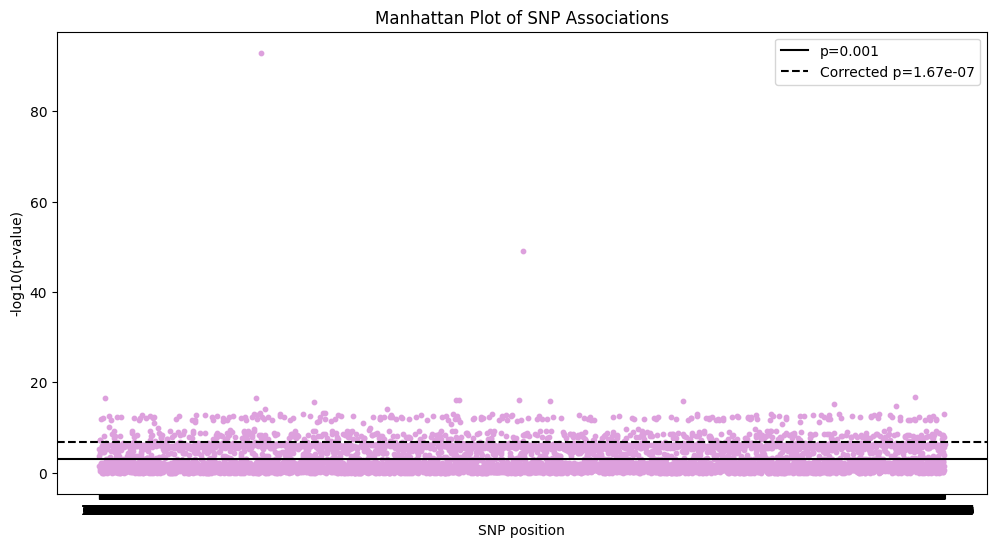

In [14]:
## -- your code here


x = df_results['SNP'] 

y = -np.log10(df_results['p_value'])


plt.figure(figsize=(12,6))   # sets the figure size 
plt.scatter(x, y, c='plum', s=10) 

plt.axhline(-np.log10(0.001), color='black', linestyle='-', label='p=0.001')
plt.axhline(-np.log10(corrected_a), color='black', linestyle='--', label=f'Corrected p={corrected_a:.2e}')

# Labels and title
plt.xlabel("SNP position")
plt.ylabel("-log10(p-value)")
plt.title("Manhattan Plot of SNP Associations")
plt.legend()
plt.show()

02F: Did using the Bonferroni correction increase or decrease the number of significant hits? Why does this make sense? Explain in 1-2 sentences (5 points)

Using the Boferroni correction significantly decreased the number of significant hits given by fewer number of points above orrected p value (the dashed horizontal line). The corrected p value adjusts for multiple hypothesis tests, which makes the significance threshold more stringent. This makes sense since it reduces false positives across all SNPs when many hypotheses are tested.